In [1]:
%pip install --quiet pandas plotly apscheduler flask flask_cors

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import sys
import json

import threading
import time

import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime, timezone


In [3]:
from flask import Flask, jsonify, send_from_directory, abort
from flask_cors import CORS

In [4]:
try:
    from apscheduler.schedulers.background import BackgroundScheduler
    APSCHEDULER_AVAILABLE = True
except Exception:
    APSCHEDULER_AVAILABLE = False

In [5]:
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
DATA_FILE = "Global_Superstore2.csv"
REFRESH_INTERVAL_MINUTES = 60

In [7]:
def load_and_clean(path=DATA_FILE):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found: {path}")

    print("Loading:", path)

    # Try UTF-8 first, fallback to ISO-8859-1
    try:
        df_raw = pd.read_csv(path, low_memory=False, encoding="utf-8")
    except UnicodeDecodeError:
        df_raw = pd.read_csv(path, low_memory=False, encoding="ISO-8859-1")

    # Display first 5 rows and shape before cleaning
    print(f"Before Cleaning: Shape = {df_raw.shape} (rows, cols)")
    display(df_raw.head())

    # Parse order date
    df_raw['Order Date'] = pd.to_datetime(df_raw['Order Date'], errors='coerce', dayfirst=True)

    # Keep only valid dates
    df = df_raw[~df_raw['Order Date'].isna()].copy()

    # Rename key columns
    df = df.rename(columns={
        'Order Date': 'order_date',
        'Sales': 'sales',
        'Profit': 'profit',
        'Quantity': 'quantity',
        'Category': 'Category',
        'Sub-Category': 'Sub-Category',
        'Region': 'Region'
    })

    # Derived time features
    df['year'] = df['order_date'].dt.year
    df['month'] = df['order_date'].dt.to_period('M')
    df['month_str'] = df['month'].astype(str)
    df['month_dt'] = df['month'].dt.to_timestamp()

    # Convert numeric safely
    for col in ['sales','profit','quantity','Discount','Shipping Cost']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Display shape after cleaning
    print(f"After Cleaning: Shape = {df.shape} (rows, cols)")
    display(df.head())

    return df


In [9]:
# Load raw dataset (without cleaning) to check missing values
try:
    df_raw = pd.read_csv(DATA_FILE, low_memory=False, encoding="utf-8")
except UnicodeDecodeError:
    df_raw = pd.read_csv(DATA_FILE, low_memory=False, encoding="ISO-8859-1")

# Count missing values per column
missing_summary = df_raw.isna().sum().sort_values(ascending=False)

# Percentage missing
missing_percent = (missing_summary / len(df_raw) * 100).round(2)

# Combine into a summary table
missing_table = pd.DataFrame({
    "Missing Count": missing_summary,
    "Missing %": missing_percent
})

# Display columns with any missing values
display(missing_table[missing_table["Missing Count"] > 0])


,Missing Count,Missing %
Postal Code,41296,80.51


In [11]:
df = load_and_clean(DATA_FILE)

Loading: Global_Superstore2.csv
Before Cleaning: Shape = (51290, 24) (rows, cols)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


After Cleaning: Shape = (51290, 28) (rows, cols)


,Row ID,Order ID,order_date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,sales,quantity,Discount,profit,Shipping Cost,Order Priority,year,month,month_str,month_dt
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,2309.650,7,0.0,762.1845,933.57,Critical,2012,2012-07,2012-07,2012-07-01
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,3709.395,9,0.1,-288.7650,923.63,Critical,2013,2013-02,2013-02,2013-02-01
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,5175.171,9,0.1,919.9710,915.49,Medium,2013,2013-10,2013-10,2013-10-01
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,2892.510,5,0.1,-96.5400,910.16,Medium,2013,2013-01,2013-01,2013-01-01
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,2832.960,8,0.0,311.5200,903.04,Critical,2013,2013-11,2013-11,2013-11-01


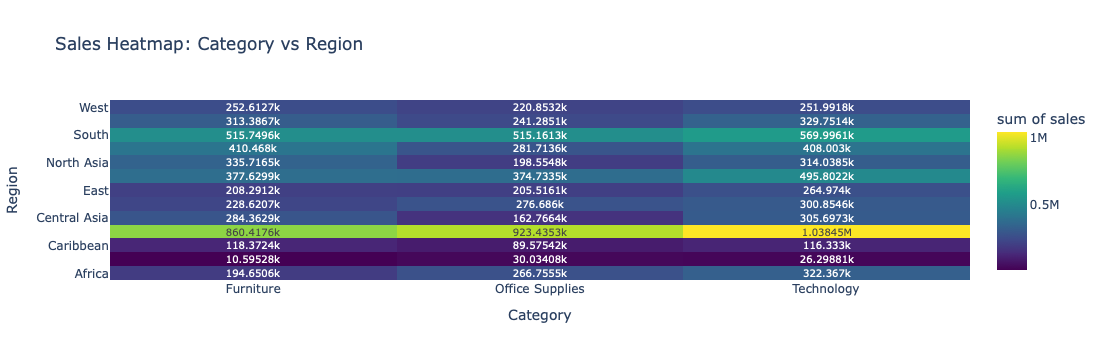

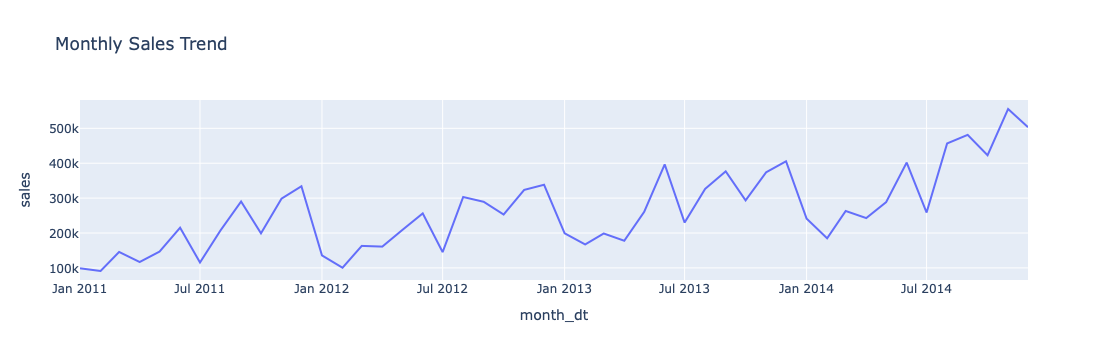

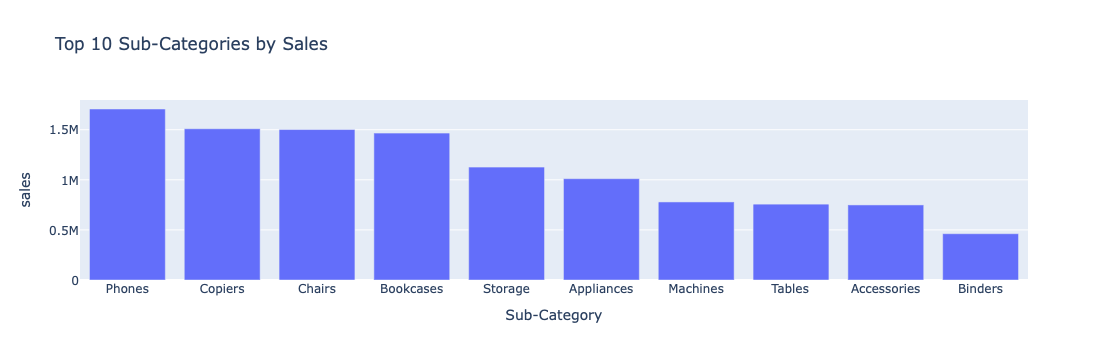

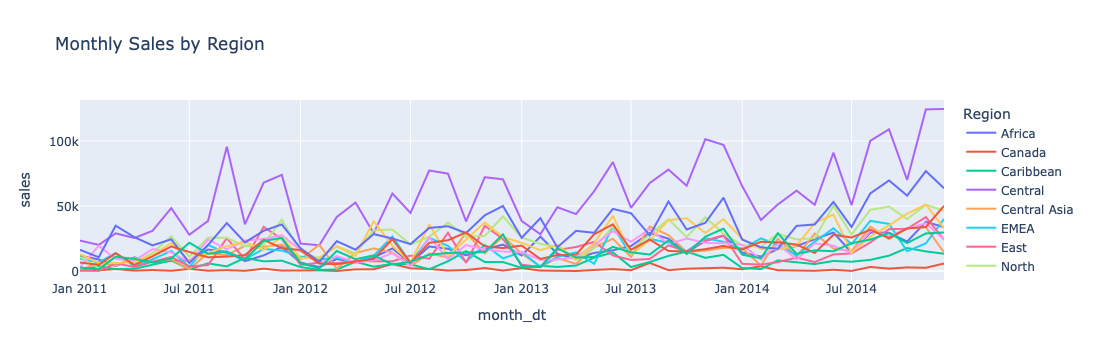

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


,Row ID,Order ID,order_date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,sales,quantity,Discount,profit,Shipping Cost,Order Priority,year,month,month_str,month_dt
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,2309.650,7,0.0,762.1845,933.57,Critical,2012,2012-07,2012-07,2012-07-01
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,3709.395,9,0.1,-288.7650,923.63,Critical,2013,2013-02,2013-02,2013-02-01
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,5175.171,9,0.1,919.9710,915.49,Medium,2013,2013-10,2013-10,2013-10-01
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,2892.510,5,0.1,-96.5400,910.16,Medium,2013,2013-01,2013-01,2013-01-01
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,2832.960,8,0.0,311.5200,903.04,Critical,2013,2013-11,2013-11,2013-11-01


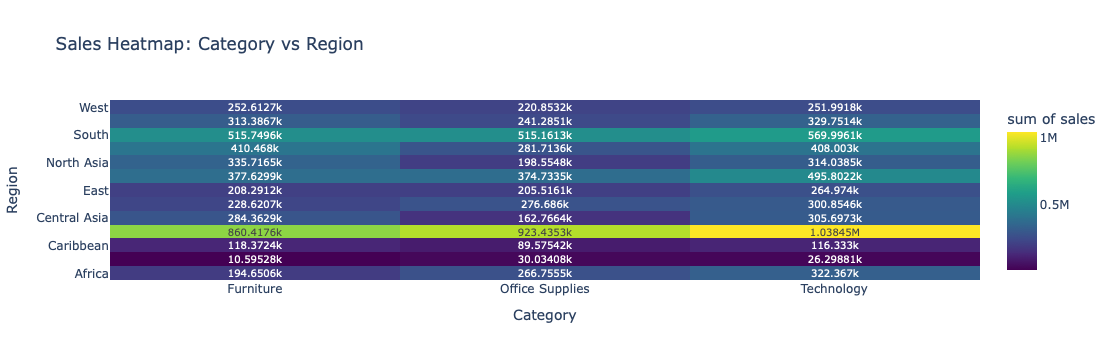

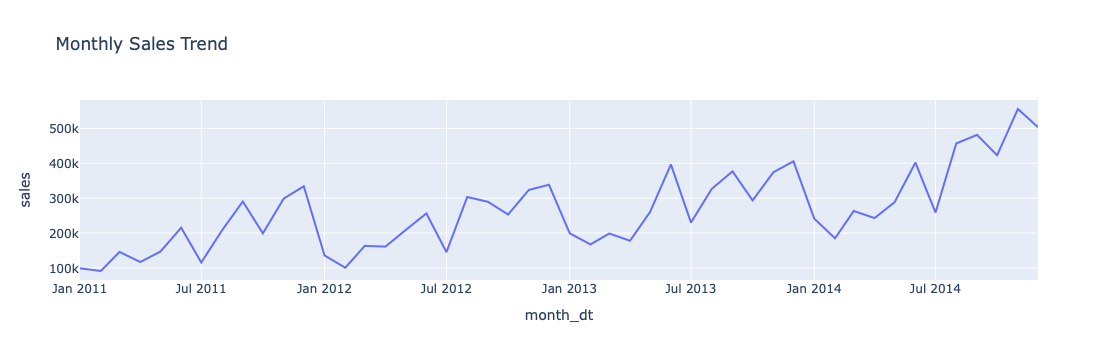

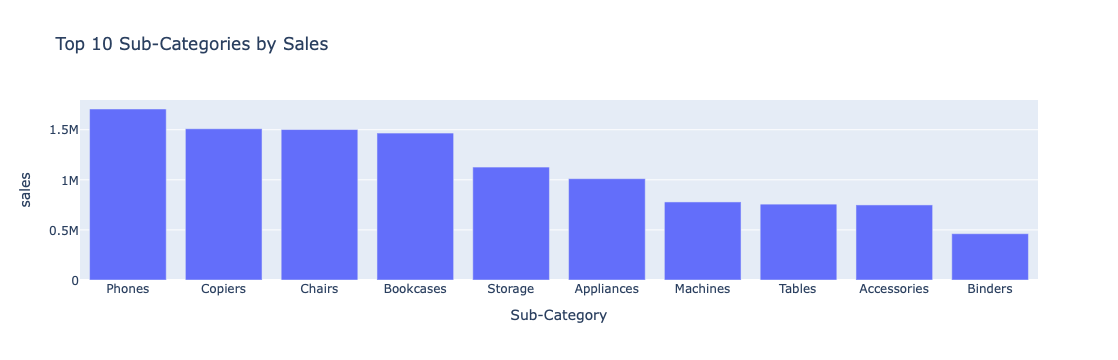

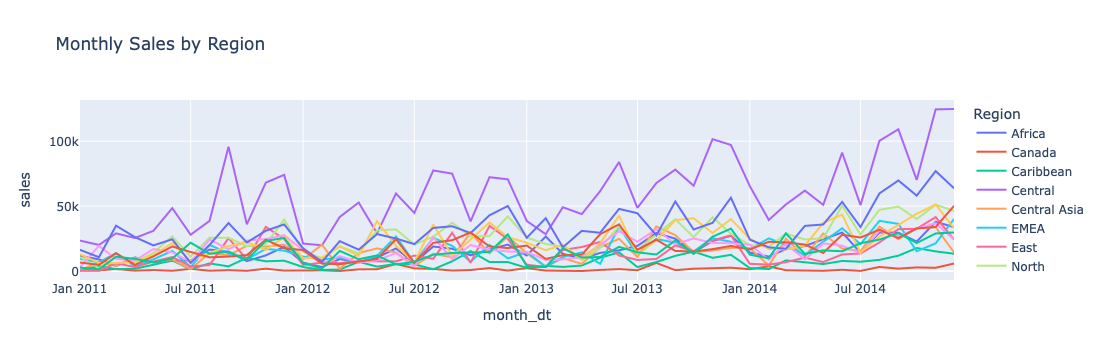

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


,Row ID,Order ID,order_date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,sales,quantity,Discount,profit,Shipping Cost,Order Priority,year,month,month_str,month_dt
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,2309.650,7,0.0,762.1845,933.57,Critical,2012,2012-07,2012-07,2012-07-01
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,3709.395,9,0.1,-288.7650,923.63,Critical,2013,2013-02,2013-02,2013-02-01
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,5175.171,9,0.1,919.9710,915.49,Medium,2013,2013-10,2013-10,2013-10-01
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,2892.510,5,0.1,-96.5400,910.16,Medium,2013,2013-01,2013-01,2013-01-01
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,2832.960,8,0.0,311.5200,903.04,Critical,2013,2013-11,2013-11,2013-11-01


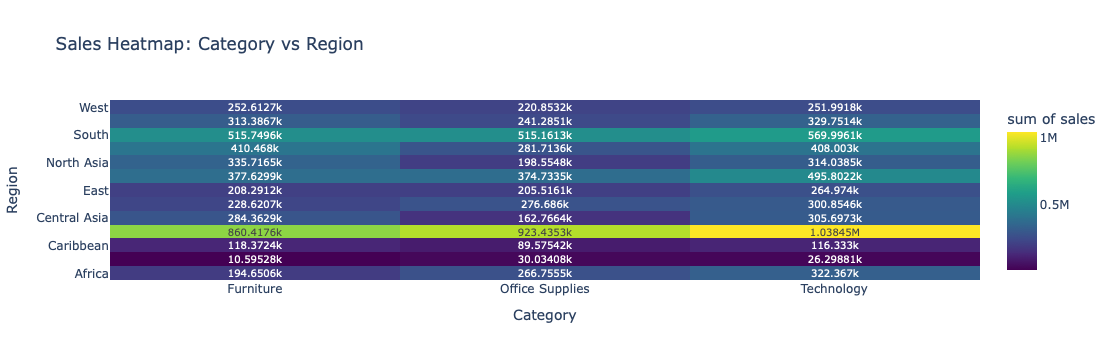

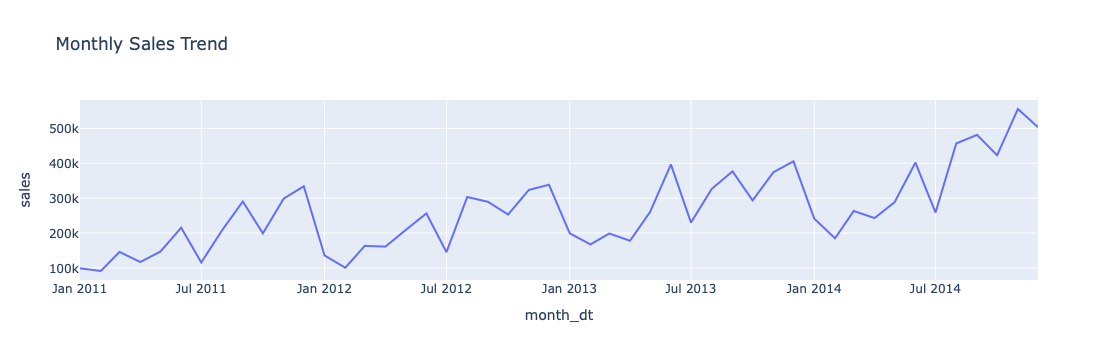

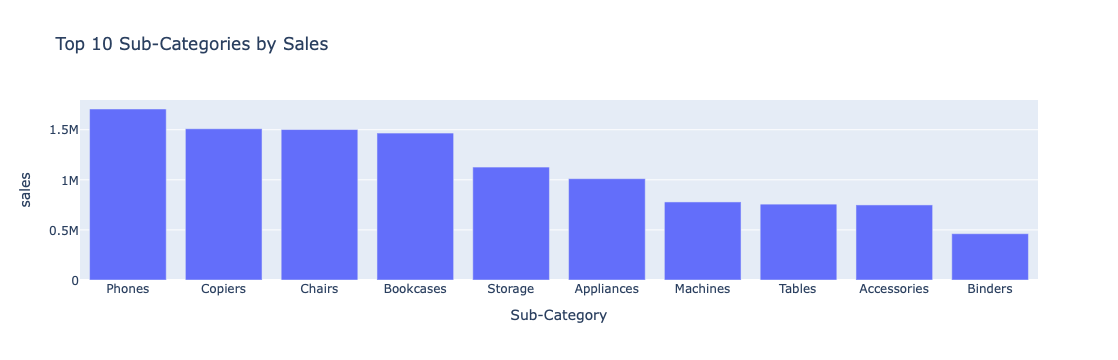

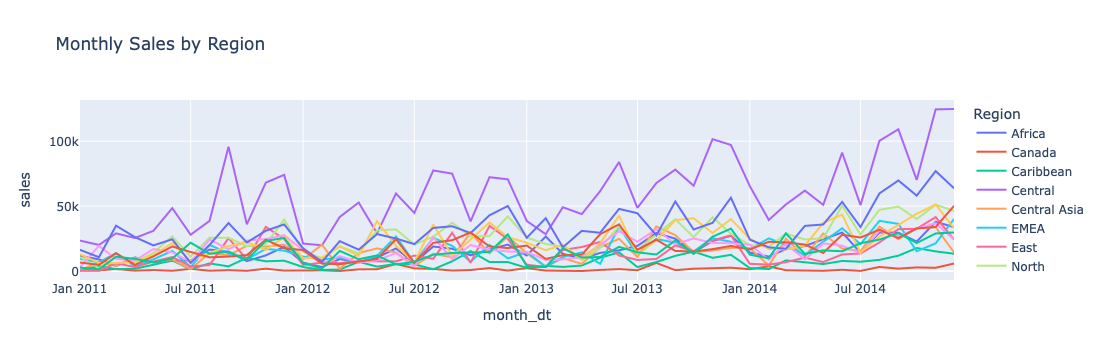

In [25]:
# Visualization and export helpers

def create_visualizations_and_exports(df, output_dir=OUTPUT_DIR, top_n=10):
    outputs = {}
    
    # 1. Heatmap: Sales by Category & Region
    heatmap_df = df.groupby(['Category','Region'])['sales'].sum().reset_index()
    fig_heatmap = px.density_heatmap(
        heatmap_df, x='Category', y='Region', z='sales',
        text_auto=True, color_continuous_scale='Viridis',
        title="Sales Heatmap: Category vs Region"
    )
    fig_heatmap.show()
    heatmap_html = os.path.join(output_dir, "sales_heatmap_category_region.html")
    heatmap_json = os.path.join(output_dir, "sales_heatmap_category_region.json")
    fig_heatmap.write_html(heatmap_html)
    fig_heatmap.write_json(heatmap_json)
    outputs['heatmap'] = [heatmap_html, heatmap_json]
    
    # 2. Monthly Sales Trend
    monthly_df = df.groupby('month_dt')['sales'].sum().reset_index()
    fig_monthly = px.line(monthly_df, x='month_dt', y='sales', title='Monthly Sales Trend')
    fig_monthly.show()
    monthly_html = os.path.join(output_dir, "monthly_sales_trend.html")
    monthly_json = os.path.join(output_dir, "monthly_sales_trend.json")
    fig_monthly.write_html(monthly_html)
    fig_monthly.write_json(monthly_json)
    outputs['monthly_trend'] = [monthly_html, monthly_json]
    
    # 3. Top Sub-Categories by Sales
    top_sub_df = df.groupby('Sub-Category')['sales'].sum().sort_values(ascending=False).head(top_n).reset_index()
    fig_sub = px.bar(top_sub_df, x='Sub-Category', y='sales', title=f'Top {top_n} Sub-Categories by Sales')
    fig_sub.show()
    top_sub_html = os.path.join(output_dir, "top_subcategories.html")
    top_sub_json = os.path.join(output_dir, "top_subcategories.json")
    fig_sub.write_html(top_sub_html)
    fig_sub.write_json(top_sub_json)
    outputs['top_subcategories'] = [top_sub_html, top_sub_json]
    
    # 4. Monthly Sales by Region
    monthly_region_df = df.groupby(['month_dt','Region'])['sales'].sum().reset_index()
    fig_monthly_region = px.line(
        monthly_region_df, x='month_dt', y='sales', color='Region',
        title='Monthly Sales by Region'
    )
    fig_monthly_region.show()
    monthly_region_html = os.path.join(output_dir, "monthly_sales_by_region.html")
    monthly_region_json = os.path.join(output_dir, "monthly_sales_by_region.json")
    fig_monthly_region.write_html(monthly_region_html)
    fig_monthly_region.write_json(monthly_region_json)
    outputs['monthly_by_region'] = [monthly_region_html, monthly_region_json]
    
    # Save cleaned full CSV
    df.to_csv(os.path.join(output_dir, "cleaned_full.csv"), index=False)
    
    # Save manifest
    manifest = {
        "generated_at": datetime.now(timezone.utc).isoformat(),
        "files": outputs
    }
    with open(os.path.join(output_dir, "manifest.json"), "w") as f:
        json.dump(manifest, f, indent=2)
    
    return outputs

# Run visualization pipeline
outputs = create_visualizations_and_exports(df, OUTPUT_DIR)


In [19]:
#Pipeline 
def run_pipeline():
    df = load_and_clean(DATA_FILE)
    outputs = create_visualizations_and_exports(df, OUTPUT_DIR)
    return outputs

# Run once now
outputs = run_pipeline()
outputs

Loading: Global_Superstore2.csv
Before Cleaning: Shape = (51290, 24) (rows, cols)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


After Cleaning: Shape = (51290, 28) (rows, cols)


,Row ID,Order ID,order_date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,sales,quantity,Discount,profit,Shipping Cost,Order Priority,year,month,month_str,month_dt
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,2309.650,7,0.0,762.1845,933.57,Critical,2012,2012-07,2012-07,2012-07-01
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,3709.395,9,0.1,-288.7650,923.63,Critical,2013,2013-02,2013-02,2013-02-01
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,5175.171,9,0.1,919.9710,915.49,Medium,2013,2013-10,2013-10,2013-10-01
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,2892.510,5,0.1,-96.5400,910.16,Medium,2013,2013-01,2013-01,2013-01-01
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,2832.960,8,0.0,311.5200,903.04,Critical,2013,2013-11,2013-11,2013-11-01


Saved outputs in: outputs


{'monthly_trend': ('outputs/monthly_sales_trend.html',
  'outputs/monthly_sales_trend.json'),
 'heatmap': ('outputs/sales_heatmap_category_region.html',
  'outputs/sales_heatmap_category_region.json'),
 'top_subcategories': ('outputs/top_subcategories.html',
  'outputs/top_subcategories.json'),
 'monthly_by_region': ('outputs/monthly_sales_by_region.html',
  'outputs/monthly_sales_by_region.json')}

In [21]:
# Scheduler for periodic refresh

if APSCHEDULER_AVAILABLE:
    scheduler = None

    def start_scheduler(interval=REFRESH_INTERVAL_MINUTES, run_immediately=True):
        global scheduler
        if scheduler is not None:
            print("Scheduler already running.")
            return scheduler
        scheduler = BackgroundScheduler()
        scheduler.add_job(run_pipeline, 'interval', minutes=interval,
                          next_run_time=datetime.now(timezone.utc) if run_immediately else None)
        scheduler.start()
        print(f"Scheduler started: every {interval} minutes.")
        return scheduler

    def stop_scheduler():
        global scheduler
        if scheduler:
            scheduler.shutdown(wait=False)
            scheduler = None
            print("Scheduler stopped.")



In [22]:
start_scheduler(REFRESH_INTERVAL_MINUTES)

Scheduler started: every 60 minutes.Loading: Global_Superstore2.csv



Before Cleaning: Shape = (51290, 24) (rows, cols)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


After Cleaning: Shape = (51290, 28) (rows, cols)


,Row ID,Order ID,order_date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,sales,quantity,Discount,profit,Shipping Cost,Order Priority,year,month,month_str,month_dt
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,2309.650,7,0.0,762.1845,933.57,Critical,2012,2012-07,2012-07,2012-07-01
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,3709.395,9,0.1,-288.7650,923.63,Critical,2013,2013-02,2013-02,2013-02-01
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,5175.171,9,0.1,919.9710,915.49,Medium,2013,2013-10,2013-10,2013-10-01
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,2892.510,5,0.1,-96.5400,910.16,Medium,2013,2013-01,2013-01,2013-01-01
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,2832.960,8,0.0,311.5200,903.04,Critical,2013,2013-11,2013-11,2013-11-01


Saved outputs in: outputs


WARNING	Thread(ThreadPoolExecutor-1_0) apscheduler.executors.default:base.py:run_job()- Run time of job "run_pipeline (trigger: interval[1:00:00], next run at: 2025-09-24 18:08:45 +0545)" was missed by 0:47:45.173237


Loading: Global_Superstore2.csv
Before Cleaning: Shape = (51290, 24) (rows, cols)
After Cleaning: Shape = (51290, 28) (rows, cols)


In [23]:
app = Flask(__name__)
CORS(app)

@app.route("/api/manifest")
def api_manifest():
    path = os.path.join(OUTPUT_DIR, "manifest.json")
    if not os.path.exists(path):
        return jsonify({"error": "no manifest"}), 404
    return jsonify(json.load(open(path)))

@app.route("/api/monthly-sales")
def api_monthly_sales():
    path = os.path.join(OUTPUT_DIR, "monthly_sales.csv")
    if not os.path.exists(path):
        return jsonify({"error":"no monthly sales"}), 404
    dfm = pd.read_csv(path)
    return jsonify(dfm.to_dict(orient="records"))

@app.route("/api/plotly/<name>")
def api_plotly(name):
    path = os.path.join(OUTPUT_DIR, f"{name}.json")
    if not os.path.exists(path):
        return jsonify({"error": "not found"}), 404
    return jsonify(json.load(open(path)))

@app.route("/html/<filename>")
def api_html(filename):
    path = os.path.join(OUTPUT_DIR, filename)
    if not os.path.exists(path):
        abort(404)
    return send_from_directory(OUTPUT_DIR, filename)

def start_flask(port=8050, host="0.0.0.0", background=True):
    if background:
        thread = threading.Thread(target=lambda: app.run(host=host, port=port, debug=False, use_reloader=False), daemon=True)
        thread.start()
        print(f"Flask running at http://{host}:{port}")
    else:
        app.run(host=host, port=port, debug=False)

In [24]:
start_flask()

Flask running at http://0.0.0.0:8050
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://192.168.1.4:8050
Press CTRL+C to quit
127.0.0.1 - - [24/Sep/2025 16:10:26] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [24/Sep/2025 16:10:26] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 -
127.0.0.1 - - [24/Sep/2025 16:10:26] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Sep/2025 16:10:26] "GET /apple-touch-icon.png HTTP/1.1" 404 -
192.168.1.4 - - [24/Sep/2025 16:10:36] "GET / HTTP/1.1" 404 -
192.168.1.4 - - [24/Sep/2025 16:10:36] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Sep/2025 16:11:09] "GET /api/plotly/monthly_sales_trend HTTP/1.1" 200 -
127.0.0.1 - - [24/Sep/2025 16:11:26] "GET /api/manifest HTTP/1.1" 200 -
